# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

In [3]:
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
bs=16
bptt=256

In [6]:
data_dir = 'data/midi/v9/'
source_dir = 'midi_encode/np/shortdur/'

file_path = Path('../../')
path = file_path/data_dir/source_dir
out_path = file_path/'data/generated/'

In [7]:
config = get_config(vocab_path=path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256}

In [8]:
data = load_data(path=path, cache_name='tmp/hook', **config)

In [9]:
saved_models = get_files(path/'models/hook', recurse=True); saved_models
load_path = saved_models[0]

In [10]:
learn = load_learner(data, config, load_path)
htlist = get_htlist(path, source_dir)

In [11]:
x,y = data.one_batch(cpu=False)

In [12]:
# ob = data.one_batch(cpu=False)
# out = learn.model(ob[0])
# out = learn.pred_batch(ob)
# learn.loss_func([c.cuda() for c in out], ob[1])

In [13]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [14]:
# learn.to_fp16();

In [15]:
# learn.fit_one_cycle(4, 2e-4)

In [16]:
# learn.save('first_run_10ep')

In [17]:
# learn.fit_one_cycle(5, 2e-4)

### From batch

In [18]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [19]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [20]:
# Loading from specific file
keywords = 'country road'.split(' ')
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')]

In [21]:
# file = np.random.choice(files)
file = search[-1]
file

PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')

In [22]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
file = Path('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [23]:
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np)[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [37]:
song_np

array([[ 2,  0],
       [ 1, 13],
       [58,  5],
       [ 1,  4],
       [60,  5],
       [ 1,  4],
       [62,  5],
       [ 1,  4],
       [63,  7],
       [58, 11],
       ...,
       [ 1,  4],
       [67,  6],
       [ 1,  4],
       [58, 11],
       [55, 11],
       [51, 11],
       [ 1,  3],
       [65,  4],
       [ 1,  3],
       [63,  7]])

### Predict

In [24]:
# res1 = torch.randint(0, 1000, (10,10)).float(); res1

# res2 = res1.pow(1 / 10)
# res2 = res2 / res2.sum()
# (res2*1000).round()/1000

# resd5 = res1.pow(1 / .5)
# resd5_prob = resd5 / resd5.sum()
# (resd5_prob*1000).round()/1000

In [25]:
def predict(self, xb, n_words:int=1, temperatures=(1.2,0.7), min_ps=(1/128,0.0), min_length=50):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = []
        outputs = self.pred_batch(batch=(xb,yb))
        for idx,item in enumerate(outputs): #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            min_p,temperature = min_ps[idx], temperatures[idx]
#             if idx == 0: print('Items over p:', (res >= min_p).float().sum(), res.shape)
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.
                
            if len(timesteps) < min_length: res[self.bos_idx] = 0.
                
            res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if self.bos_idx is not None and (bar==self.bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead

    self.model[0].mask = True
    return timesteps, seed.squeeze()


In [ ]:
def predict(self, xb, n_words:int=1, temperatures=(1.2,0.7), min_ps=(1/128,0.0), min_length=50):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = []
        outputs = self.pred_batch(batch=(xb,yb))
        for idx,item in enumerate(outputs): #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            min_p,temperature = min_ps[idx], temperatures[idx]
#             if idx == 0: print('Items over p:', (res >= min_p).float().sum(), res.shape)
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.
                
            if len(timesteps) < min_length: res[self.bos_idx] = 0.
                
            res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if self.bos_idx is not None and (bar==self.bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead

    self.model[0].mask = True
    return timesteps, seed.squeeze()


In [26]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [27]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

In [28]:
out, seed = predict(learn, xb, n_words=340, temperatures=(1.5,0.9), min_ps=(1/128,0.0))

Predicted BOS token. Returning prediction...


### Actual prediction

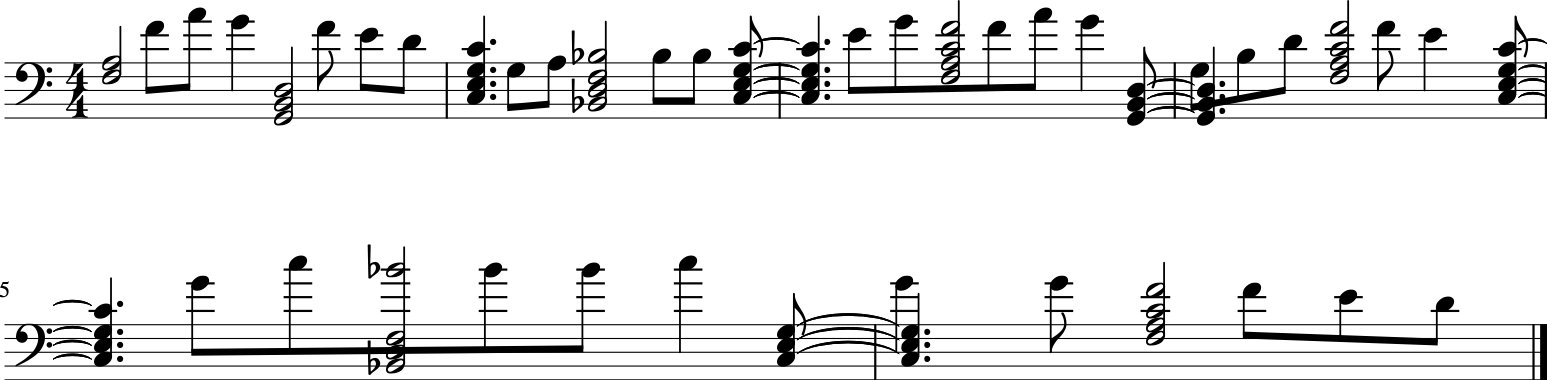

In [29]:
stream = npenc2stream(out)
stream.show()

In [30]:
stream.show('midi')

## Seed

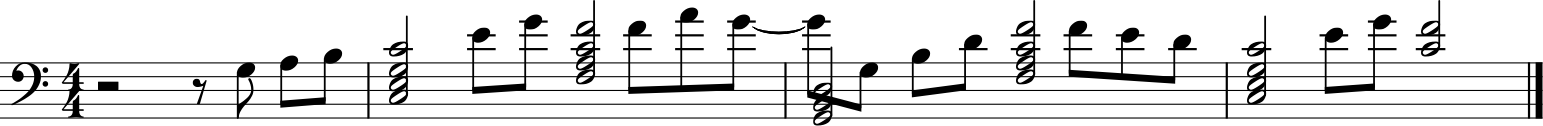

In [31]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [32]:
seed_stream.show('midi')

## Alltogether now

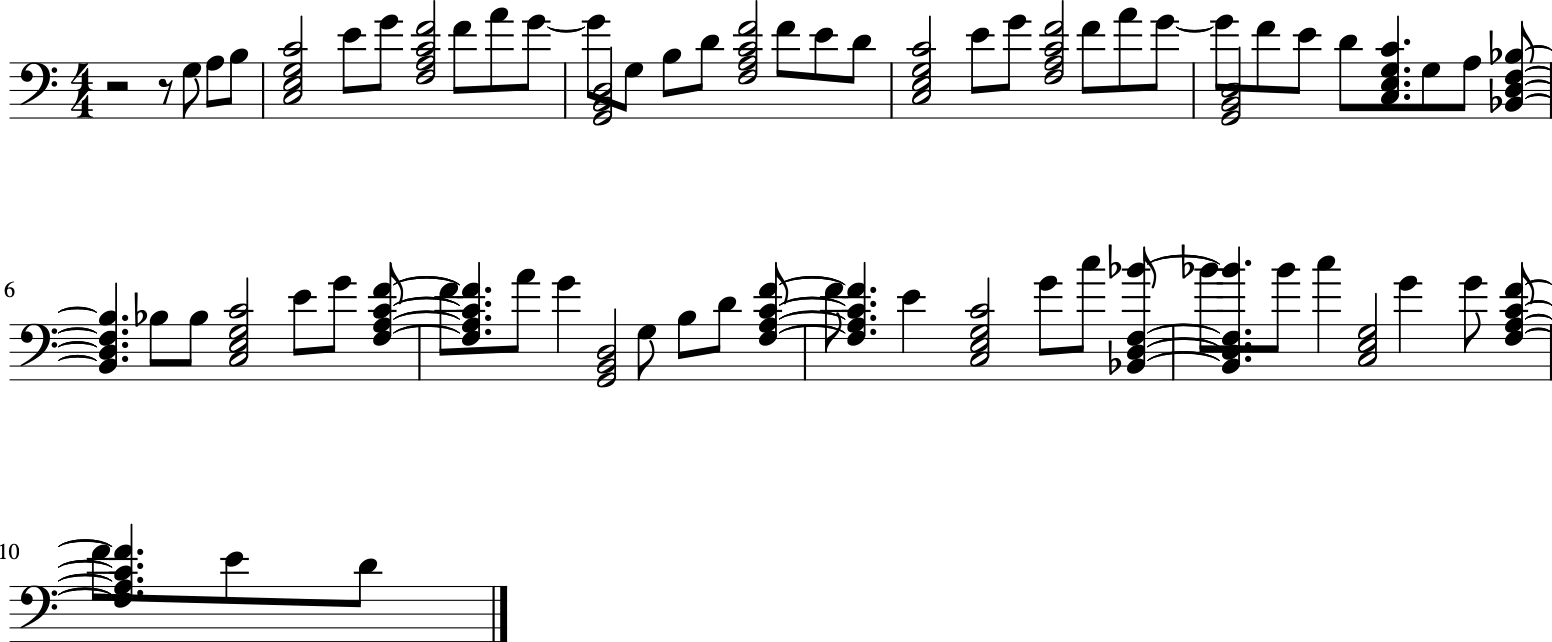

In [33]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [34]:
full_stream.show('midi')

### Original

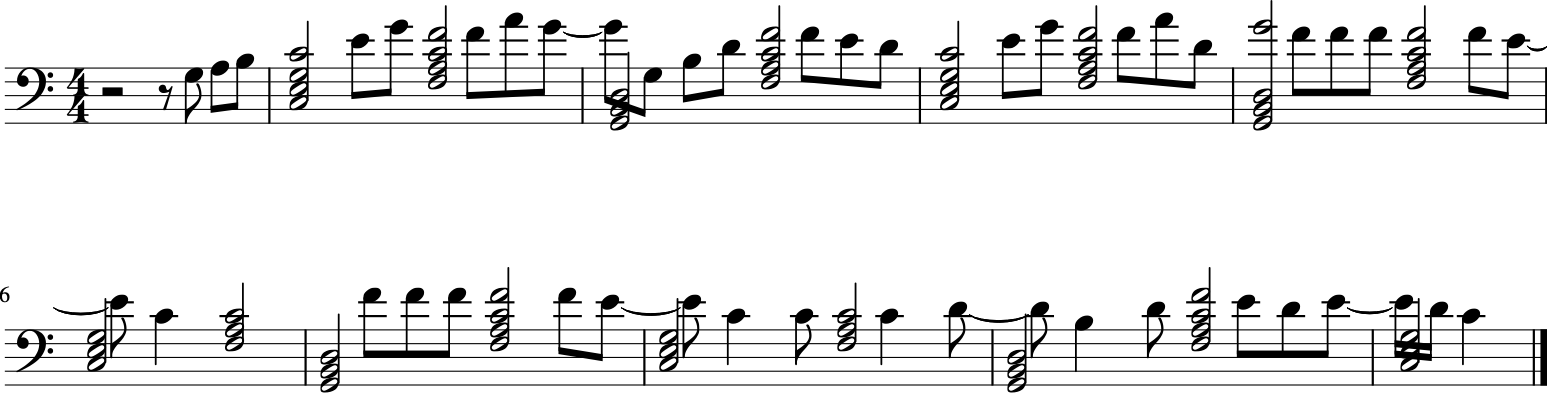

In [35]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [36]:
original_stream.show('midi')